Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = "Федорова Арина"
COLLABORATORS = ""

---

In [ ]:
import numpy as np
from scipy.linalg import block_diag

Рассмотрим систему линейных уравнений, матрица правой части которой является "ленточной" и имеет следующую структуру: ненулевые элементы расположены на трех центральных диагонялях и на двух "крыльях". Матрицы такой структуры возникают, например, при решении задачи на нахождение электростатического потенциала $\phi(x, y)$, cоздаваемого двумерным распределением заряда $\rho(x, y)$ при дискретизации на сетке уравнения Пуассона

$$
\Delta \phi = -4\pi \rho\;.
$$

(детали см. напр. А.А. Самарский, А.В. Гулин, Численные методы, ч. 3 гл. 1, параграф 1).

Размер матрицы растет с уменьшением шага сетки $h$ как $O(1/h^2)$. Таким образом, приходится иметь дело с разреженными матрицами огромного размера.

Матрицу `m` создадим следующим образом:

In [ ]:
def lhs_matrix(n):
    # Диагональный блок
    a = np.zeros((n-1, n-1))

    idx = np.arange(n-1)

    a[idx, idx] = -4
    a[idx[:-1], idx[:-1]+1] = 1
    a[idx[1:], idx[1:]-1] = 1

    # собираем блочно-диагональную матрицу `m`
    m = block_diag(*(a,)*n)

    # заполняем "крылья"
    idx = np.arange(m.shape[0])

    m[idx[:-n+1], idx[:-n+1] + n-1] = 1
    m[idx[n-1:], idx[n-1:] - n+1] = 1
    return m

In [ ]:
m = lhs_matrix(5)

with np.printoptions(linewidth=99):
    print(m)

[[-4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0

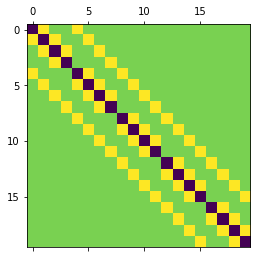

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(m)

Зададим вектор правой части системы $b$, символизирующий точечный заряд в центре:

In [ ]:
b = np.zeros(m.shape[0])
b[m.shape[0]//2] = -1

Составьте функцию, вычисляющую решение системы уравнений $m x = b$ **методом Зейделя** с заданной точностью $\epsilon$.

Не пользуйтесь функциями `np.linalg.solve`, `np.linalg.inv` и т.п. Обратите внимание на функции `np.triu` и `scipy.linalg.solve_triangular`.

In [ ]:
from scipy.linalg import solve_triangular

def seidel_solve(m, b, x0, eps=1e-5, maxiter=500):
    """ Solve `m @ x = b` with Seidel iteration.
    
    Parameters
    ----------
    m : ndarray, shape (n, n)
       Input matrix
    b : ndarray, shape (n,)
       Right-hand side
    x0 : ndarray, shape (n, )
       Initial point for the iteration
    eps : float, optional
       Target accuracy.
       Stop iterations when the 2-norm of 
       `|x_k - x_{k-1}| < eps`
    maxiter : int
       Maximum allowed number of iterations.
       
    Returns
    -------
    x : ndarray, shape (n,)
       The approximation to the solution of `m @ x = b`
    nit : the number of iterations performed.
    """
    a = m.T
    LD = np.triu(a).T
    U = m - LD

    nit = 0 
    error = 1000
    x_new = x0 

    while error > eps and nit < maxiter:
      nit += 1
      x = solve_triangular(LD, b - U @ x_new, lower=True)
      error = np.linalg.norm(x - x_new)
      x_new = x
    return x_new, nit

In [ ]:
m = lhs_matrix(n=6)
b = np.zeros(m.shape[0])
b[b.size//2] = 1

x0 = np.ones(m.shape[0])
x, nit = seidel_solve(m, b, x0)

from numpy.testing import assert_allclose
assert_allclose(x,
                np.linalg.solve(m, b), atol=2e-5)


Прокомментируйте зависимость числа итераций, требуемых для достижения заданной точности, от $\epsilon$. (без оценки)

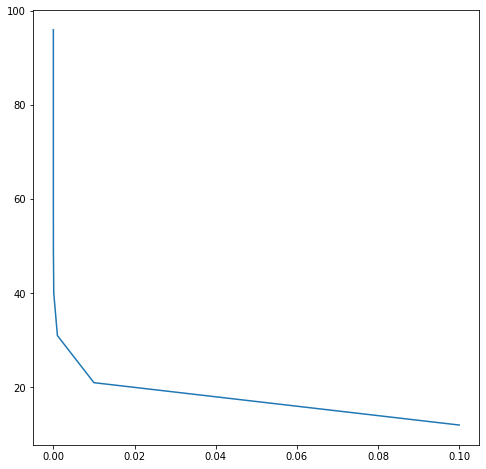

In [ ]:
import matplotlib.pyplot as plt

list_accur = [] 
list_it = [] 
for i in range(1, 11):
  list_accur.append((1e-1)**i)
for i in list_accur:
  list_it.append(seidel_solve(m, b, x0, eps=i)[1])

plt.figure(figsize=(8, 8))
plt.plot(list_accur, list_it)

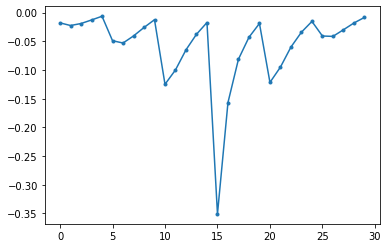

In [ ]:
# Постройте график решения как функцию индекса компоненты вектора. 
# Прокомментируйте характер зависимости (без оценки).
plt.plot(x, '.-')